### Применение  нейронной сети LSTM

In [ ]:
!pip install keras >> null

In [ ]:
!pip install tensorflow >> null

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import tensorflow.keras as keras
from keras.layers import  GRU

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('dataset.csv', header=0, infer_datetime_format=True,
                   parse_dates=['course_finished_date'], index_col=['course_finished_date'])

/var/folders/4d/01h37whs1gsddkj2yj7jszjh0000gn/T/ipykernel_12721/2255855955.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('dataset.csv', header=0, infer_datetime_format=True,


In [4]:
# Выбор целевой переменной и масштабирование данных
scaler = MinMaxScaler()
df['course_duration_scaled'] = scaler.fit_transform(df[['course_duration_sum']])

In [5]:
# Создание последовательности временных рядов
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length])
    return np.array(X), np.array(y)


In [6]:
# Определение параметров модели
sequence_length = 10  # Длина последовательности (количество предыдущих точек данных, используемых для прогнозирования следующей)
n_features = 1  # Количество признаков (в нашем случае это продолжительность курса)


In [7]:
# Создание последовательностей для обучения
X, y = create_sequences(df['course_duration_scaled'], sequence_length)


In [7]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test = X[:365], X[365:-30]
y_train, y_test = y[:365], y[365:-30]

In [8]:
# Создание и обучение модели LSTM
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# Остановка обучения, если нет улучшений
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)


In [10]:
# Обучение модели
history = model.fit(X_train, y_train, epochs=100, batch_size=13, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0543 - val_loss: 0.0161
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0104 - val_loss: 0.0078
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0081 - val_loss: 0.0063
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0064
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - val_loss: 0.0074
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - val_loss: 0.0069
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0067


In [11]:
# Оценка модели
loss = model.evaluate(X_test, y_test)
print('Test Loss:', loss)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 
Test Loss: 0.009455186314880848


In [12]:
# Прогнозирование на тестовом наборе данных
y_pred = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [13]:
# Инвертирование масштабирования
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

In [14]:
# Оценка качества модели
mse = mean_squared_error(y_test_inv, y_pred_inv)
print('RMSE:', mse**0.5)

RMSE: 264.1124212384727


In [15]:
# преобразование датасета для построения графика
y_test_n = [el[0] for el in y_test_inv]
y_pred_n = [el[0] for el in y_pred_inv]
result_df = pd.DataFrame()
result_df["test"] = y_test_n
result_df["pred"] = y_pred_n
result_df.index = df.index[375:-30]

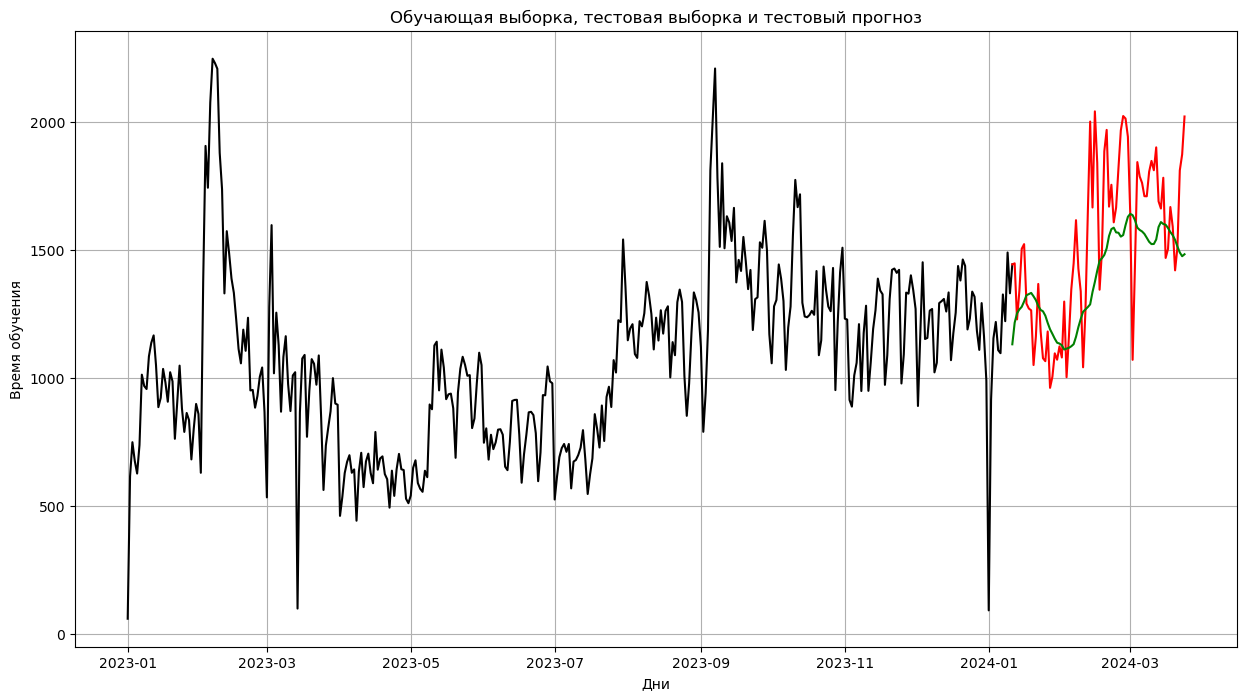

In [19]:
# выведем три кривые (обучающая, тестовая выборка и тестовый прогноз)
plt.figure(figsize=(15,8))
plt.plot(df['course_duration_sum'][:365+11], color = "black")
plt.plot(result_df["test"], color = "red")
plt.plot(result_df["pred"], color = "green")
 
# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Время обучения')
plt.xlabel('Дни')
 
# добавим сетку
plt.grid()
 
plt.show()

Оценка качества модели на отрезке в 7 дней

In [11]:
X_train, X_test = X[:-37], X[-37:-30]
y_train, y_test = y[:-37], y[-37:-30]
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, n_features)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=13, callbacks=[early_stopping])

y_pred = model.predict(X_test)

y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
print('RMSE:', mse**0.5)

Epoch 1/100


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0809
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 3/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0025

/opt/anaconda3/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0095
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0059
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0077
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067
Epoch 16/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065
Epoch 17/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064
Epoch 18/100
3

In [12]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
print('RMSE:', mse**0.5)

RMSE: 198.09405006541323
